# Main simiulation

In [30]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
import sqlite3
from matplotlib.patches import Circle
from shapely import Polygon
import numpy as np
from jupedsim.internal.notebook_utils import read_sqlite_file
import plotly.graph_objects as go

%matplotlib inline


from Py.riskSimulationValues import RiskSimulationValues
from Py.dangerSimulation import *
from Py.animation import animate
from Py.simulation_config import SimulationConfig
from Py.agentGroup import AgentGroup
from Py.settingPaths import *
from Py.agent_area_writer import *
import polygons.environmnet as pol
from Py.simulation_logic import compute_current_nodes
from Py.journey_configuration import set_journeys

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

## Choosing the Environment

In [31]:
# Environment = pol.get_simple_3x3()
Environment = pol.get_comparing_algorithms_pol()

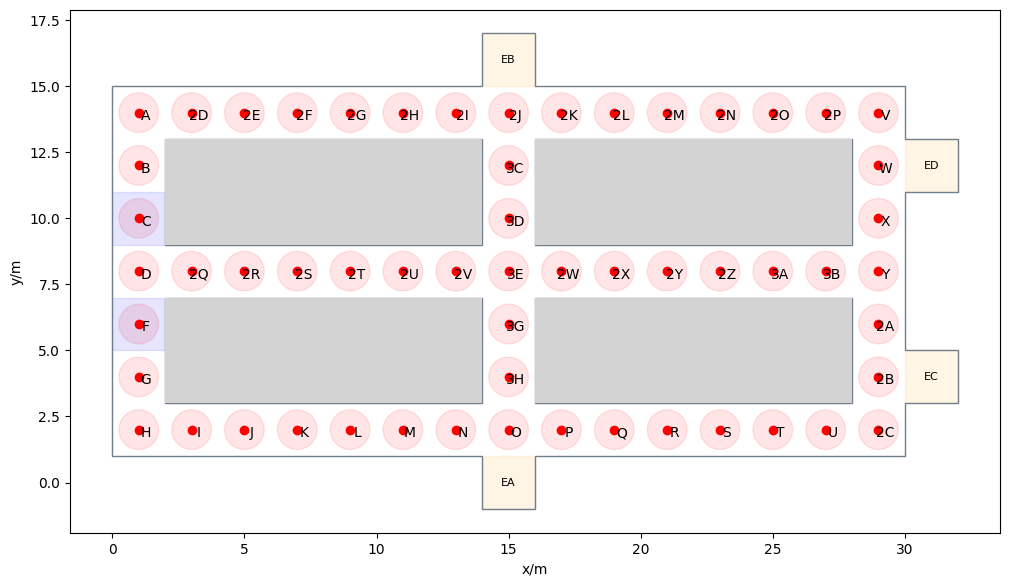

In [32]:
Environment_name = Environment.name
complete_area = Environment.complete_area
obstacles = Environment.obstacles
exit_polygons = Environment.exit_polygons
waypoints = Environment.waypoints
distribution_polygons = Environment.distribution_polygons
obstacle = Environment.obstacles
walkable_area = Environment.walkable_area
G = Environment.G
sources = Environment.sources
targets = Environment.targets
specific_areas = Environment.specific_areas

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in waypoints.items():
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"{idx}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(5, -5),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)
for name, exit_polygon in exit_polygons.items():
    x, y = Polygon(exit_polygon).exterior.xy
    plt.fill(x, y, alpha=0.1, color="orange")
    centroid = Polygon(exit_polygon).centroid
    plt.text(centroid.x, centroid.y, f"{name}", ha="center", va="center", fontsize=8)

for name, pol in distribution_polygons.items():
    x, y = pol.exterior.xy
    plt.fill(x, y, alpha=0.1, color="blue")

In [33]:
def remove_obstacles_from_areas(specific_areas, obstacles):
    """
    Removes obstacles from specific areas by subtracting overlapping polygons.

    Args:
        specific_areas (dict): Dictionary of named areas {name: Polygon}.
        obstacles (list): List of Polygon objects representing obstacles.

    Returns:
        dict: Dictionary of cleaned areas {name: Polygon without obstacles}.
    """
    cleaned_areas = {}

    for name, area in specific_areas.items():
        # Subtract all obstacles from the current area
        cleaned_area = area
        for obstacle in obstacles:
            if cleaned_area.intersects(obstacle):  # Only process if they overlap
                cleaned_area = cleaned_area.difference(obstacle)

        # Store the cleaned area in the dictionary
        cleaned_areas[name] = cleaned_area

    return cleaned_areas

## Configuration of Simulation Scenarios

In [34]:
# Dictionary to store simulations for different percentages of agents
simulations = {}

# List of modes of algorithms and awareness used for the simulation
modes = [0, 1, 2, 3]

# Total number of agents in the simulation (not currently used in this snippet)
total_agents = 5

# Loop over each percentage value to create a corresponding simulation
for mode in modes:
    # Define the output file path for storing the simulation trajectories
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"

    # Create a new simulation instance using JPS (JuPedSim)
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(  # Define the agent movement model
            strength_neighbor_repulsion=2.6,  # Strength of repulsion between neighboring agents
            range_neighbor_repulsion=0.1,  # Distance at which agents start repelling each other
            range_geometry_repulsion=0.05,  # Distance at which agents start avoiding obstacles
        ),
        geometry=walkable_area.polygon,  # Define the walkable area for the simulation
        trajectory_writer=jps.SqliteTrajectoryWriter(  # Specify where to store simulation results
            output_file=pathlib.Path(trajectory_file),  # Save output to the specified SQLite file
        ),
    )

    # Store the simulation object in the dictionary using the percentage as a key
    simulations[mode] = simulation

## Journey configuration

In [35]:
# In journey_configuration.py

## Allocate Agents

In [36]:
positions = dict()
for source in sources:
    positions[source] = jps.distribute_by_number(
        polygon=distribution_polygons[source],
        number_of_agents=total_agents,
        distance_to_agents=0.4,
        distance_to_polygon=0.5,
        seed=45131502,
    )

## Launching the Simulation

In [37]:
def update_group_paths(simulation_config, risk_per_node, agent_group, G, risk_threshold=0.5):
    """
    Updates the group's path based on the current status of each agent using the provided current_nodes mapping.

    The process is as follows:
      1. Verify that the agents_ids list exists.
      2. Depending on the awareness_level:
           - If it is 1, only the first agent of the group is evaluated.
           - Otherwise, all agents are evaluated.
      3. For each selected agent, using its current node (from current_nodes), determine the next node
         in the current path. Then, check if the path needs to be changed.
         If for any agent a change is needed, update the path for the entire group,
         stop further checks, and return the updated agent_group.

    Args:
        simulation_config (SimulationConfig): Contains:
            - simulation: Object that manages the simulation (agents and environment).
            - every_nth_frame (int): Interval at which agent paths are updated.
            - waypoints_ids (dict): Mapping from graph nodes to simulation waypoint IDs.
            - journeys_ids (dict): Mapping of journey identifiers to tuples (journey_id, path).
        risk_per_node (dict): Mapping of each node to its risk value.
        agent_group (AgentGroup): An AgentGroup instance containing:
            - agents (list): List of agent IDs.
            - path (list): List representing the group's current path.
            - algorithm (int): Identifier for the algorithm used.
            - awareness_level (int): The awareness level of the agents.
            - current_node: The current node (to be updated if changed).
        G: Graph or structure used for computing alternative paths.
        current_nodes (dict): A dictionary where keys are agent IDs and values are the agent's current node.
        risk_threshold (float): Threshold above which a path segment is considered unsafe.

    Returns:
        AgentGroup: The updated AgentGroup with the new path if a change was made,
                    or the original AgentGroup if no update occurred.
    """
    agents_ids = agent_group.agents

    # First, check that agents_ids exists.
    if not agents_ids:
        return agent_group

    current_path = agent_group.path
    current_nodes = agent_group.current_nodes
    simulation = simulation_config.simulation
    waypoints_ids = simulation_config.waypoints_ids

    # Select the list of agents to evaluate:
    # If awareness_level is 1, only evaluate the first agent.
    if agent_group.awareness_level == 1:
        agents_to_check = [agents_ids[0]]
    else:
        agents_to_check = agents_ids

    for agent_id in agents_to_check:
        # Verify that the agent exists in the simulation.
        agent_exists = any(agent.id == agent_id for agent in simulation.agents())
        if not agent_exists:
            return agent_group  # If any agent doesn't exist, return the original group.

        # Ensure the current node is provided in current_nodes.
        if agent_id not in current_nodes:
            return agent_group

        # Get the current node from the dictionary.
        current_node = current_nodes[agent_id]

        # Attempt to obtain the index of the current node in the current path.
        try:
            node_index = current_path.index(current_node)
        except ValueError:
            return agent_group

        # If the current node is the last node in the path, no update is needed.
        if node_index == len(current_path) - 1:
            continue

        # The next node in the path is the one immediately after the current node.
        next_node = current_path[node_index + 1]

        # Calculate an alternative path from the current_node to the next_node.
        best_path = compute_alternative_path(
            simulation_config.get_exit_ids_keys(),
            agent_group, G,
            current_node, next_node,
            risk_per_node, risk_threshold,
            simulation_config.gamma
        )

        # If a valid alternative path is found and it is different from the current path...
        if best_path is not None and not is_sublist(best_path, current_path):
            journeys_ids = set_journeys(
                simulation, current_node,
                [best_path],
                waypoints_ids, simulation_config.exit_ids
            )
            # Assume best_path has at least two nodes.
            new_next_node = best_path[1]
            next_stage_id = waypoints_ids[new_next_node]
            new_journey_id, _ = journeys_ids[current_node][0]

            # Update the journey for ALL agents in the group.
            for agent_id in agents_ids:
                simulation.switch_agent_journey(agent_id, new_journey_id, next_stage_id)

            agent_group.path = best_path

            # Return the updated agent group with the new path.
            return agent_group

    # If no update was made, return the original agent_group.
    return agent_group


In [38]:
def simulate_risk(riskSimulationValues, every_nth_frame, G, exits, connection):
    """
    Simulates risk propagation in a graph over multiple frames and stores the results in a database.

    Args:
        riskSimulationValues: An object that includes the simulation parameters:
            - iterations (int): Total number of frames to simulate.
            - propagation_chance (float): Probability of risk spreading between connected nodes.
            - increase_chance (float): Probability of individual nodes increasing their risk.
        every_nth_frame (int): Interval of frames at which risk updates are performed.
        G (networkx.Graph): Graph where each node has a "risk" attribute.
        exits (list): List of nodes whose risk remains 0.
        connection (sqlite3.Connection): Open SQLite database connection to store risk data.
    """
    # Validate the input arguments
    if riskSimulationValues.iterations <= 0:
        raise ValueError("iterations must be a positive integer.")
    if every_nth_frame <= 0:
        raise ValueError("every_nth_frame must be a positive integer.")

    for frame in range(riskSimulationValues.iterations + 1):
        if frame == 0:
            # Ensure that exit nodes have risk 0
            for exit_node in exits:
                if exit_node in G.nodes:
                    G.nodes[exit_node]["risk"] = 0
            # Save the initial risk levels of all nodes before any updates
            try:
                write_risk_levels(connection, 0, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error writing initial risks: {e}")
            continue

        # directly use the iteration as frames
        if frame % every_nth_frame == 0:
            try:
                # Update risks in the graph based on propagation and increase chances
                update_risk(G,riskSimulationValues.increase_chance, riskSimulationValues.danger_threshold)

                # Ensure that exit nodes retain a risk of 0 after the update
                for exit_node in exits:
                    if exit_node in G.nodes:
                        G.nodes[exit_node]["risk"] = 0

                # Save the updated risk levels for the current frame
                write_risk_levels(connection, frame, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error updating risks at frame {frame}: {e}")

In [39]:
def run_agent_simulation(simulation_config, agent_groups, G, connection, agent_area_connection, risk_threshold):
    """
    Runs the agent simulation, updating agent paths based on current risk levels retrieved from the database.

    Args:
        simulation_config (SimulationConfig): An instance of SimulationConfig containing:
            - simulation: The simulation object managing agents and the environment.
            - every_nth_frame (int): The interval at which agent paths are updated.
            - waypoints_ids (dict): Mapping of graph node IDs to simulation waypoint IDs.
        agent_groups (dict): Mapping of starting nodes to AgentGroups.
        risk_threshold (float): The risk level threshold above which agents will attempt to avoid high-risk areas.
    """
    while simulation_config.simulation.agent_count() > 0:
        # Advance the simulation by one frame
        simulation_config.simulation.iterate()
        iteration = simulation_config.simulation.iteration_count()

        every_nth_frame_simulation = simulation_config.every_nth_frame_simulation
        every_nth_frame_animation = simulation_config.every_nth_frame_animation

        if iteration % every_nth_frame_simulation == 0:
            frame = iteration / every_nth_frame_simulation

            # Update agent paths only at specified intervals
            if frame % every_nth_frame_animation == 0:
                try:
                    # Fetch risk levels for the current frame from the database
                    risks_this_frame = get_risk_levels_by_frame(connection, frame)

                    for key, agent_group in agent_groups.items():
                        # This first so that there are no confusions when the path is changed
                        compute_current_nodes(simulation_config, agent_group, frame)
                        # Write in which area the agents are in this frame
                        write_agent_area(agent_area_connection, frame, agent_group.agents, agent_group.current_nodes, risks_this_frame)

                        # Update paths for the agents based on current risks and threshold
                        agent_groups[key] = update_group_paths(
                            simulation_config, risks_this_frame, agent_group, G, risk_threshold=risk_threshold
                        )
                except Exception as e:
                    print(f"Error updating paths at frame {frame}: {e}")

In [40]:
def set_agents_in_simulation(simulation, positions, journey_id, first_waypoint_id):
    agents = []
    for position in positions:  # Use the second half of the positions
        # Add agents with specified parameters (e.g., position, journey, velocity)
        agents.append(
            simulation.add_agent(
                jps.CollisionFreeSpeedModelAgentParameters(
                    position=position,       # Initial position of the agent
                    journey_id=journey_id,   # Journey ID for the agent
                    stage_id=first_waypoint_id,  # Starting waypoint for the agent
                    v0=0.8, # Desired maximum speed of the agent
                )
            )
        )
    return agents

In [41]:
# False -> to use the default risk evolution, True -> random risk evolution
use_random_risk_layout = False

# Important parameters
risk_threshold = 0.5
gamma = 0.4

# set agent groups
modes_names = ["Low_awareness_efficient_paths", "High_awareness_efficient_paths", "Low_awareness_centrality_path", "High_awareness_centrality_path"]
awareness_levels_per_group = [0, 1, 0, 1]
algorithm_per_group = [0, 0, 1, 1]

In [42]:
every_nth_frame_simulation = 4  # Interval of iterations for frames
                                # 4 is the simulation writers default

every_nth_frame_animation = 50  # Interval of frames for risk updates
                                # 50 is the animations default

# Simulation parameters
riskSimulationValues = RiskSimulationValues(3000, 0.05, risk_threshold)

# Establish a connection to the appropriate SQLite database
default_connection_file = f"../../sqlite_data/default_{Environment_name}_risks.db" # default risk evolution file
new_connection_file = f"../../sqlite_data/{Environment_name}_risks.db" # random risk evolution file
if use_random_risk_layout:
    connection_file = new_connection_file  # Use new database if random risk layout is enabled
else:
    connection_file = new_connection_file  # Use default database otherwise

connection = sqlite3.connect(connection_file)
try:
    if use_random_risk_layout:
        # Create or reset the risk table if random risk layout is enabled
        create_risk_table(connection)

        # Simulate risk propagation and store results in the database
        simulate_risk(riskSimulationValues, every_nth_frame_animation, G, exit_polygons.keys(), connection) # animation not every frame is shown in the animation
    # get first frame risk table
    risk_first_frame= get_risk_levels_by_frame(connection, 0)
finally:
    # Ensure the database connection is closed after operations
    connection.close()

In [43]:
trajectory_files = {}
agent_groups_per_mode = {}
agent_area_files = {}
for mode, simulation in simulations.items():

    agent_area_files[mode] = f"../../sqlite_data/agent_area_{Environment_name}_mode_{mode}.db"
    agent_area_connection = sqlite3.connect(agent_area_files[mode])

    create_agent_area_table(agent_area_connection)

    exit_ids = {}
    for node, exit_polygon in exit_polygons.items():
        exit_ids[node] = simulation.add_exit_stage(exit_polygon)

    # Initialize a dictionary to store waypoint IDs
    waypoints_ids = {}
    # Convert waypoints into simulation waypoints with associated distances
    for node, (waypoint, distance) in waypoints.items():
        waypoints_ids[node] = simulation.add_waypoint_stage(waypoint, distance)

    agent_groups = dict()
    for source in sources:

        agent_group_aux = AgentGroup(None, None, None, algorithm_per_group[mode], awareness_levels_per_group[mode])
        path = compute_alternative_path(exit_polygons.keys(), agent_group_aux, G, source, risk_per_node=risk_first_frame, gamma=gamma)

        # Set up a journey for the simulation
        journeys_ids = set_journeys(
            simulation, source, [path], waypoints_ids, exit_ids
        )

        # Retrieve the best path for the first source and its associated journey ID
        journey_id, best_path_source = journeys_ids[source][0]
        next_node = best_path_source[1]  # Get the next node on the best path
        first_waypoint_id = waypoints_ids[next_node]  # Determine the waypoint ID for the next node

        agents = set_agents_in_simulation(simulation, positions[source], journey_id, first_waypoint_id)

        agent_group_aux.path = path

        # currently unnecessary
        agents_initial_nodes = {}
        for agent in agents:
            agents_initial_nodes[agent] = path[0]
        agent_group_aux.current_nodes = agents_initial_nodes

        agent_group_aux.agents = agents

        agent_groups[source] = agent_group_aux

    simulation_config = SimulationConfig(simulation, every_nth_frame_simulation, every_nth_frame_animation, waypoints_ids, exit_ids, gamma)

    connection = sqlite3.connect(connection_file)
    # Run the agent simulation, updating paths based on the risk levels
    run_agent_simulation(
        simulation_config,
        agent_groups,
        G,
        connection,
        agent_area_connection,
        risk_threshold=risk_threshold,  # Threshold for avoiding high-risk areas
    )

    connection.close()
    agent_area_connection.close()

    # Generate the trajectory file for the current percentage and store its path
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"
    trajectory_files[mode] = trajectory_file
    agent_groups_per_mode[mode] = agent_groups

In [44]:
# Open the database connection safely
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks = get_risks_grouped_by_frame(connection)

    # Iterate over the nested dictionary
    for frame, areas in all_risks.items():  # 'areas' is a dictionary {area: risk_level}
        for area, risk in areas.items():
            print(f"Frame {frame}, Area {area}: Risk Level {risk}")

# Connection automatically closes when 'with' block ends

Frame 0, Area 2A: Risk Level 0.0
Frame 0, Area 2B: Risk Level 0.0
Frame 0, Area 2C: Risk Level 0.0
Frame 0, Area 2D: Risk Level 0.0
Frame 0, Area 2E: Risk Level 0.0
Frame 0, Area 2F: Risk Level 0.0
Frame 0, Area 2G: Risk Level 0.0
Frame 0, Area 2H: Risk Level 0.0
Frame 0, Area 2I: Risk Level 0.0
Frame 0, Area 2J: Risk Level 0.0
Frame 0, Area 2K: Risk Level 0.0
Frame 0, Area 2L: Risk Level 0.0
Frame 0, Area 2M: Risk Level 0.0
Frame 0, Area 2N: Risk Level 0.0
Frame 0, Area 2O: Risk Level 0.0
Frame 0, Area 2P: Risk Level 0.0
Frame 0, Area 2Q: Risk Level 0.0
Frame 0, Area 2R: Risk Level 0.0
Frame 0, Area 2S: Risk Level 0.0
Frame 0, Area 2T: Risk Level 0.0
Frame 0, Area 2U: Risk Level 0.0
Frame 0, Area 2V: Risk Level 0.0
Frame 0, Area 2W: Risk Level 0.0
Frame 0, Area 2X: Risk Level 0.0
Frame 0, Area 2Y: Risk Level 0.0
Frame 0, Area 2Z: Risk Level 0.0
Frame 0, Area 3A: Risk Level 0.0
Frame 0, Area 3B: Risk Level 0.0
Frame 0, Area 3C: Risk Level 0.0
Frame 0, Area 3D: Risk Level 0.0
Frame 0, A

In [45]:
with sqlite3.connect(agent_area_files[2]) as connection:
    all_agent_areas = read_agent_area_data_by_frame(connection,500)
    print(all_agent_areas)

   frame  agent_id area  risk
0    500        61   3E   0.2
1    500        62   2V   0.0
2    500        63   3E   0.2
3    500        64   2V   0.0
4    500        65   2V   0.0
5    500        66   2U   0.0
6    500        67   3E   0.2
7    500        68   2V   0.0
8    500        69   3G   0.3
9    500        70   2V   0.0


## Visualizing Agent Pathways

In [46]:
agent_trajectories = {}
for mode in modes:
    trajectory_file = trajectory_files[mode]
    agent_trajectories[mode], walkable_area = read_sqlite_file(
        trajectory_file
    )
    animate(
        agent_trajectories[mode],
        walkable_area,
        title_note=f"Mode: {modes_names[mode]}",
        risk_per_frame=all_risks,
        specific_areas=specific_areas
    ).show()

## Analysus if the results

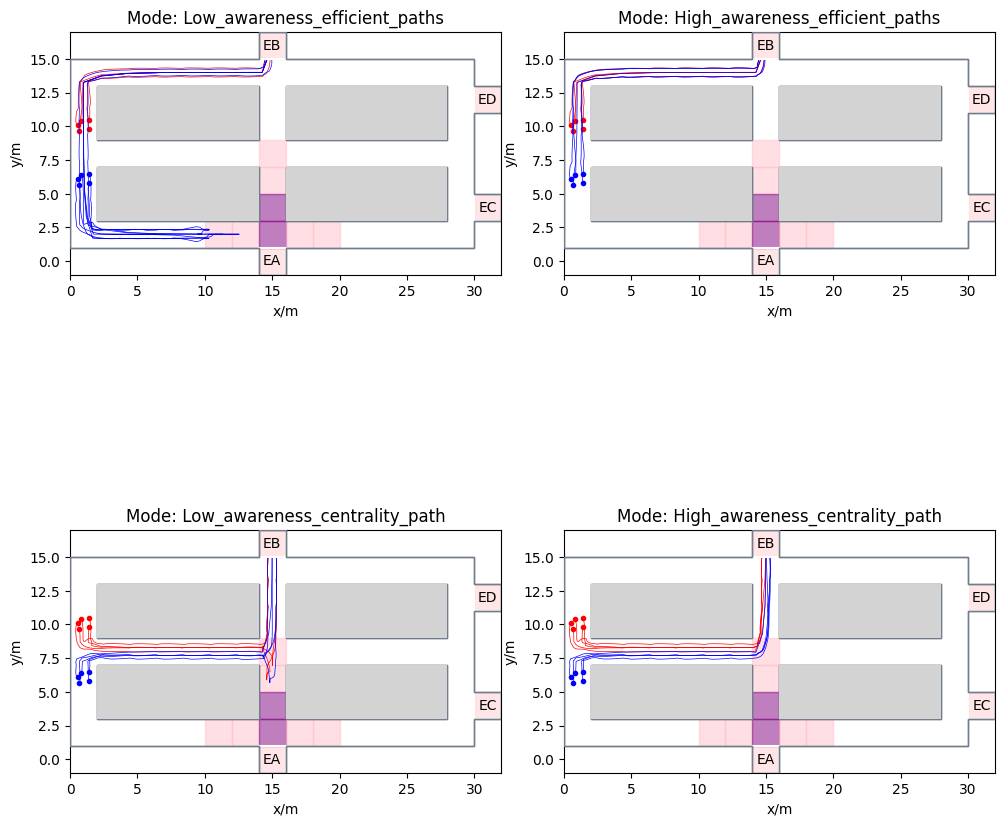

In [61]:
# show the hazzards of a specific frame
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks_frame_550 = get_risk_levels_by_frame(connection, 400)

risky_areas = []
for area, risk in all_risks_frame_550.items():
    if risk > 0.0:
        risky_areas.append((area, risk))

# Retrieve the boundary coordinates of the complete_area polygon
minx, miny, maxx, maxy = complete_area.bounds

# Create a figure with subplots arranged in two rows and two columns
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 16),
)

# Flatten the axes array to simplify iteration
axes = axes.flatten()

# Define a list of colors to differentiate agent groups in the plots
colors = ["red", "blue"]

# Iterate over each subplot axis and its corresponding mode
for ax, mode in zip(axes, agent_groups_per_mode):
    # Extract trajectory data for the current mode
    trajectories = agent_trajectories[mode].data

    # Initialize a list to hold groups of agents for the current mode
    list_of_groups = []

    # Populate the list with agent groups from each source
    for source in sources:
        list_of_groups.append(agent_groups_per_mode[mode][source].agents)

    # Iterate over each group of agents
    for ig, group in enumerate(list_of_groups):
        # Create a TrajectoryData object for the current group
        traj = pedpy.TrajectoryData(
            trajectories[trajectories["id"].isin(group)],
            frame_rate=agent_trajectories[mode].frame_rate,
        )

        # Plot the trajectories of the current group on the current axis
        pedpy.plot_trajectories(
            traj=traj,
            walkable_area=walkable_area,
            axes=ax,
            traj_color=colors[ig],
            traj_width=0.5,
            traj_start_marker=".",
        )

    # Set the title of the subplot to indicate the current mode
    ax.set_title(f"Mode: {modes_names[mode]}")

    # Set the x and y axis limits based on the complete_area boundaries
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Ensure the aspect ratio is equal to maintain the scale of the plot
    ax.set_aspect('equal', adjustable='box')

    # Overlay exit polygons on the plot
    for name, exit_polygon in exit_polygons.items():
        # Extract the x and y coordinates of the polygon's exterior
        x, y = Polygon(exit_polygon).exterior.xy

        # Fill the polygon area with a semi-transparent red color
        ax.fill(x, y, alpha=0.1, color="red")

        # Outline the polygon with a white border
        ax.plot(x, y, color="white")

        # Calculate the centroid of the polygon
        centroid = Polygon(exit_polygon).centroid

        # Place the name of the exit at the centroid position
        ax.text(
            centroid.x, centroid.y, name, ha="center", va="center", fontsize=10
        )


    for area, risk_value in risky_areas:
        if risk_value > 0.0:
            x, y = specific_areas[area].exterior.xy
            if risk_value < risk_threshold:
                ax.fill(x, y, alpha=0.5, color="pink")
            else:
                ax.fill(x, y, alpha=0.5, color="purple")


# Adjust the layout to prevent overlapping elements
plt.tight_layout()

# Set the final size of the figure if needed
fig.set_size_inches((10, 12))

# Display the figure with all subplots
plt.show()


## Calculate profiles

### Step 1: Compute individual speeds and Voronoi cells for each mode

In [48]:
individual_speed_per_mode = dict()
individual_voronoi_cells_per_mode = dict()

# Loop over each mode in the list of modes
for mode in modes:
    # Compute individual speed for the current mode
    individual_speed = pedpy.compute_individual_speed(
        traj_data=agent_trajectories[mode],
        frame_step=5,
        speed_calculation=pedpy.SpeedCalculation.BORDER_SINGLE_SIDED,
    )

    # Compute individual Voronoi polygons for the current mode
    individual_voronoi_cells = pedpy.compute_individual_voronoi_polygons(
        traj_data=agent_trajectories[mode],
        walkable_area=walkable_area,
        cut_off=pedpy.Cutoff(radius=0.8, quad_segments=3),
    )

    # Save the computed data into dictionaries keyed by mode
    individual_speed_per_mode[mode] = individual_speed
    individual_voronoi_cells_per_mode[mode] = individual_voronoi_cells

### Step 2: Compute density and speed profiles for each mode

In [49]:
# Define the frame range for profile computation
min_frame_profiles = 600
max_frame_profiles = 700

# Initialize dictionaries to store density and speed profiles per mode
density_profiles_per_mode = dict()
speed_profiles_per_mode = dict()

# Loop over each mode to calculate the profiles
for mode in modes:
    # Filter the Voronoi data for frames within the desired range
    voronoi_filtered = individual_voronoi_cells_per_mode[mode][
        individual_voronoi_cells_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Filter the speed data for frames within the desired range
    speed_filtered = individual_speed_per_mode[mode][
        individual_speed_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Merge the filtered Voronoi and speed data on 'id' and 'frame'
    merged_data = pd.merge(
        voronoi_filtered,
        speed_filtered,
        on=["id", "frame"],
    )

    # Compute density and speed profiles using the merged data
    density_profiles, speed_profiles = pedpy.compute_profiles(
        individual_voronoi_speed_data=merged_data,
        walkable_area=walkable_area.polygon,
        grid_size=0.25,
        speed_method=pedpy.SpeedMethod.ARITHMETIC,
    )

    # Save the computed profiles in the corresponding dictionaries
    density_profiles_per_mode[mode] = density_profiles
    speed_profiles_per_mode[mode] = speed_profiles

### Step 3: Plot profiles with one row per mode and two columns per row
<div style="margin-left: 60px;"><h4>(first column: density, second column: speed)</h4></div>


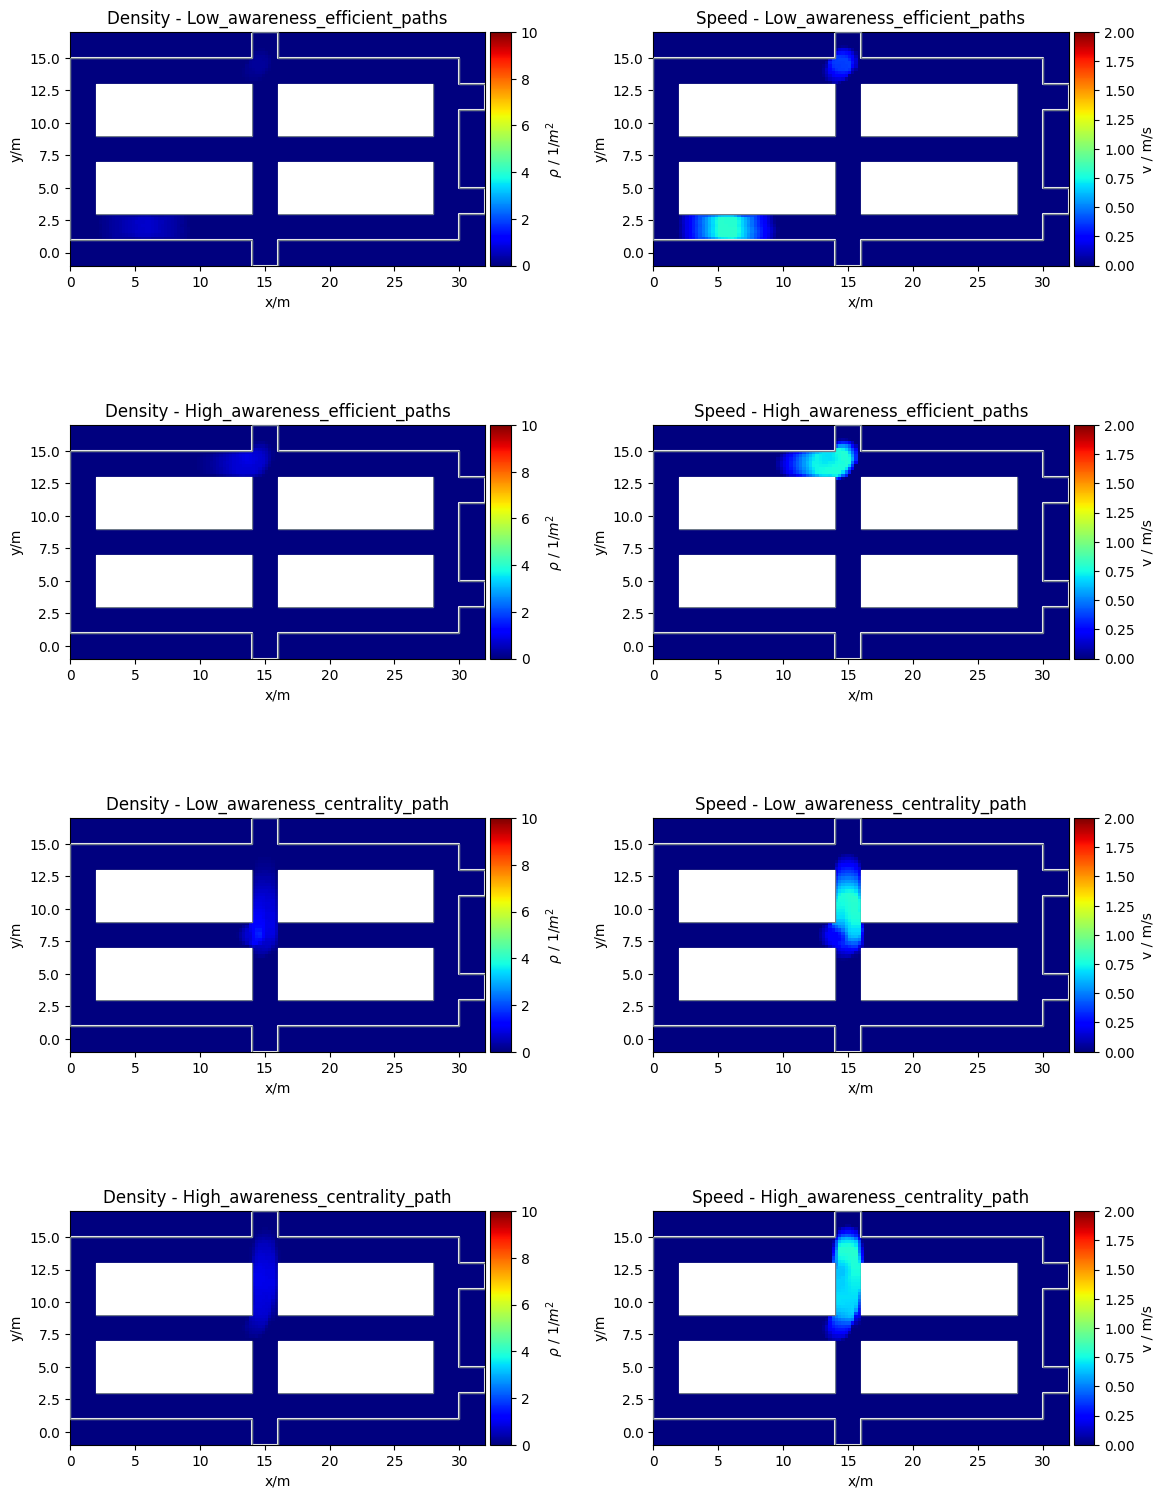

In [50]:
num_modes = len(modes)
fig, axes = plt.subplots(nrows=num_modes, ncols=2, figsize=(12, 4 * num_modes))

for idx, mode in enumerate(modes):
    # Seleccionamos el eje para densidad (columna 0) y para velocidad (columna 1)
    ax_density = axes[idx, 0]
    ax_speed = axes[idx, 1]

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=density_profiles_per_mode[mode],
        axes=ax_density,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=10,
        title=f"Density - {modes_names[mode]}",
    )

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=speed_profiles_per_mode[mode],
        axes=ax_speed,
        label="v / m/s",
        vmin=0,
        vmax=2,
        title=f"Speed - {modes_names[mode]}",
    )

fig.tight_layout(pad=2)
plt.show()

## Evacuation Times vs Mode

In [51]:
evac_times = []
for mode, traj in agent_trajectories.items():
    t_evac = traj.data["frame"].max() / traj.frame_rate # time equals frame / frame rate
    evac_times.append(t_evac)

for mode in modes:
    print(f"Mode: {modes_names[mode]}, time: {evac_times[mode]:2f}")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(modes_names),
        y=evac_times,
        marker=dict(size=10),
        mode="lines+markers",
        name="Evacuation Times",
    )
)

fig.update_layout(
    title="Evacuation Times vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Evacuation Time (s)",
)

fig.show()

Mode: Low_awareness_efficient_paths, time: 66.520000
Mode: High_awareness_efficient_paths, time: 30.560000
Mode: Low_awareness_centrality_path, time: 37.400000
Mode: High_awareness_centrality_path, time: 34.920000


## Risk vs Mode

In [52]:
avg_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            avg_risk[mode] = get_average_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, average risk: {avg_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(avg_risk.values()),
        name="Average Risks"
    )
)

fig.update_layout(
    title="Average Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

Mode: Low_awareness_efficient_paths, average risk: 0.1
Mode: High_awareness_efficient_paths, average risk: 0.0
Mode: Low_awareness_centrality_path, average risk: 0.1
Mode: High_awareness_centrality_path, average risk: 0.1


In [53]:
risk_sum = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            risk_sum[mode] = calculate_average_agent_combined_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, total risk: {risk_sum[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(risk_sum.values()),
        name="Total Risks"
    )
)

fig.update_layout(
    title="Total Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

Mode: Low_awareness_efficient_paths, total risk: 0.2
Mode: High_awareness_efficient_paths, total risk: 0.0
Mode: Low_awareness_centrality_path, total risk: 0.6
Mode: High_awareness_centrality_path, total risk: 0.3


In [54]:
highest_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            highest_risk[mode] = get_max_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, highest risk: {highest_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(highest_risk.values()),
        name="Highest Risks"
    )
)

fig.update_layout(
    title="Highest Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

Mode: Low_awareness_efficient_paths, highest risk: 0.3
Mode: High_awareness_efficient_paths, highest risk: 0.0
Mode: Low_awareness_centrality_path, highest risk: 0.3
Mode: High_awareness_centrality_path, highest risk: 0.2
